In [2]:
#!/usr/bin/python
import sys
sys.path.append("../tools/")
sys.path.append("../scripts/")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from helper import get_features, predict_from_score, correlate, crt_plot, plt_precision_recall_vs_threshold, plt_precision_vs_recall, plot_roc_curve, flex_classifier 

import pickle

from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, load_classifier_and_data, test_classifier

MODELS = '../classifiers/'
IMAGES = '../images/'
DATA   = '../data/'

----

In [3]:
#############################
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
# features_list = ['poi','salary'] # You will need to use more features
payment_features = ['salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments', 'other', 'expenses', 'director_fees', 'total_payments']
stock_features   = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']
mail_features    = ['from_this_person_to_poi', 'from_poi_to_this_person', 'shared_receipt_with_poi']
extra_features   = ['bonus_deferral_payments_rate', 'rest_stock_deferral_payments_rate', 'exer_stock_options_deferral_payments_rate',
                    'long_term_incentive_total_payments_rate', 'bonus_total_payments_rate', 'exer_stock_options_total_payments_rate',
                    'toPOI_rate', 'fromPOI_rate']
extra_finance    = ['bonus_deferral_payments_rate', 'rest_stock_deferral_payments_rate', 'exer_stock_options_deferral_payments_rate',
                    'long_term_incentive_total_payments_rate', 'bonus_total_payments_rate', 'exer_stock_options_total_payments_rate']
extra_mail       = ['toPOI_rate', 'fromPOI_rate']
feature_list = payment_features + stock_features + mail_features + extra_features

In [4]:
### Load the dictionary containing the dataset
my_data = pd.read_pickle(DATA+"my_dataFrame.pkl")
# Divide data into features and labels 
y = my_data['poi'].copy().astype(np.uint8)
X = my_data[feature_list].copy()
# Split data into training and test set using stratified splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=77, stratify=y) 

----

In [5]:
# I spare 30% of the data as test set to have at least 5 'poi's in the test set. It's important to me to realize a high recall value, identifying as many 'poi's as possible.  
print "Number of POIs in the test set:" , y_test.sum()

Number of POIs in the test set: 6


In [6]:
# Save the order of insiders
insiders_train = y_train.index
insiders_test  = y_test.index

In [7]:
# Dealing with missing values
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### Imputation Stategies

In [8]:
# I'd like to explore different strategies filling NAN values
# Imputer_01:
# Applies median to mail and extra NAN features and 0 to financial NAN features
impute_01 = ColumnTransformer(
     [('finance_data',  SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0), payment_features+stock_features),
      ('mail_data',     SimpleImputer(missing_values=np.nan, strategy='median'), mail_features),
      ('extra_finance', SimpleImputer(missing_values=np.nan, strategy='median'), extra_finance),
      ('extra_mail',    SimpleImputer(missing_values=np.nan, strategy='median'), extra_mail)],
     remainder='passthrough')
# Imputer_02:
# Applies median to all NAN features 
impute_02 = SimpleImputer(strategy='median')
# Imputer_03:
# Applies 0.0 to all NAN features
impute_03 = SimpleImputer(strategy='constant', fill_value=0.0)
# Imputer 04
# Applies 0.0 to financial and extra_finance featurtes and median to 'mail_features' and 'extra_mail'
impute_04 = ColumnTransformer(
     [('finance_data',  SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0), payment_features+stock_features),
      ('mail_data',     SimpleImputer(missing_values=np.nan, strategy='median'), mail_features),
      ('extra_finance', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0), extra_finance),
      ('extra_mail',    SimpleImputer(missing_values=np.nan, strategy='median'), extra_mail)],
     remainder='passthrough')
# Imputer 05
# Applies mean values to all NAN
impute_05 = SimpleImputer(strategy='mean')
imputers = [impute_01, impute_02, impute_03, impute_04, impute_05]

### Scaling strategies

In [9]:
def no_scaling(X):
    return np.array(X)

In [10]:
# Define different scaling strategies
#no_scl     = FunctionTransformer(func=lambda x: np.array(x))
no_scl     = FunctionTransformer(func=no_scaling)
robust_scl = RobustScaler()
std_scl    = StandardScaler()
power_scl  = PowerTransformer(method='yeo-johnson')
scalers = [no_scl, robust_scl, std_scl, power_scl]
scaler_names = ['NO SCALING', 'ROBUST SCALER', 'STANDARD SCALER', 'POWER SCALER']

----

### Forest Tree

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
RandF_clf = RandomForestClassifier(random_state=77, n_estimators=100, max_features="sqrt", max_depth=None, min_samples_split=2, bootstrap=True)

In [13]:
# Build pipelines for imputation and scaling
pipe_41 = Pipeline([ ('impute_04', impute_04), ('scale', no_scl) ])
pipe_44 = Pipeline([ ('impute_04', impute_04), ('scale', power_scl) ])

X_train_41 = pipe_41.fit_transform(X_train);
X_train_44 = pipe_44.fit_transform(X_train);

X_test_41  = pipe_41.fit_transform(X_test);

C:\Users\micha\Programs\anaconda3\envs\py27\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


----

## Feature selection

### Try different sets of features and check the impact on the results (ROC AUC)

In [14]:
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

### Initial run of Forest Tree 

In [15]:
scores = cross_val_score(RandF_clf, X_train_41, y_train, cv=6, scoring='roc_auc')
scores.mean()

0.8466269841269841

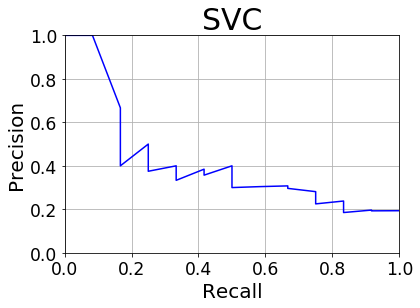

In [16]:
y_scores = cross_val_predict(RandF_clf, X_train_41, y_train, cv=6, method='predict_proba' )
roc_auc_score(y_train, y_scores[:,1])
precision, recall, proba = precision_recall_curve(y_train, y_scores[:,1])
plt_precision_vs_recall(precision, recall, title='SVC')

#### Feature reduction

In [17]:
from sklearn.feature_selection import RFE, RFECV

In [18]:
RFE_ = RFE(RandF_clf).fit(X_train_41, y_train)

In [19]:
RFE_.ranking_

array([ 1,  1,  1,  3, 11,  4,  1, 13,  1,  1,  1, 10,  1,  5,  7,  2,  9,
       12,  6,  1,  1,  1,  1,  8])

In [20]:
RFE_ = RFE(RandF_clf).fit(X_train_44, y_train)

In [21]:
RFE_.ranking_

array([ 1,  1,  1,  3, 11,  4,  1, 13,  1,  1,  1, 10,  1,  5,  7,  2,  9,
       12,  6,  1,  1,  1,  1,  8])

Scaling does not have an impact on the feature importance

In [22]:
X_train_44_red = pipe_44.transform(X_train)[:, RFE_.ranking_ <= 1]
X_test_44_red = pipe_44.transform(X_test)[:, RFE_.ranking_ <= 1]

0.8167613636363636 ROC AUC for


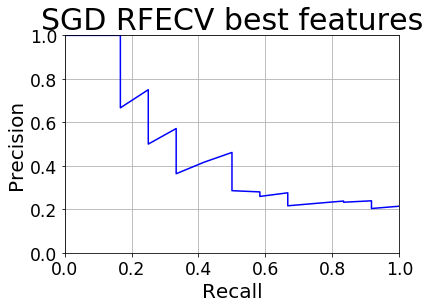

In [23]:
# RFECV features reduction. RFB Kernel results.
y_scores = cross_val_predict(RandF_clf, X_train_44_red, y_train, cv=6, method='predict_proba')
print roc_auc_score(y_train, y_scores[:,1]), "ROC AUC for"
precision, recall, proba = precision_recall_curve(y_train, y_scores[:,1])
plt_precision_vs_recall(precision, recall, title='SGD RFECV best features')

In [24]:
score_table = pd.DataFrame(zip(feature_list, RFE_.ranking_))
score_table.sort_values(1, axis='index')

,0,1
0,salary,1
12,total_stock_value,1
22,toPOI_rate,1
10,restricted_stock,1
9,exercised_stock_options,1
19,long_term_incentive_total_payments_rate,1
20,bonus_total_payments_rate,1
8,total_payments,1
21,exer_stock_options_total_payments_rate,1
2,long_term_incentive,1


### Grid search and Randomized search of Hyperparameters

In [25]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [26]:
param_grid = [
    {
        #'n_estimators': [100, 200, 500, 1000], 
        'n_estimators': [1000],
        'max_features': ['sqrt', None, 'log2'],
        'bootstrap': [True, False],
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': np.linspace(0.,1., 5)
    }
]

In [27]:
gridSch = GridSearchCV(RandF_clf, param_grid=param_grid, return_train_score=True, cv=6, scoring='roc_auc', verbose=1, refit=True, n_jobs=8, iid=False)

In [28]:
gridSch.fit(X_train_41, y_train);

Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   38.9s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:  1.2min finished


In [29]:
gridSch.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_features': 'sqrt',
 'min_impurity_decrease': 0.0,
 'n_estimators': 1000}

In [30]:
grid_results = pd.DataFrame(gridSch.cv_results_)

In [31]:
grid_results.columns

Index([u'mean_fit_time', u'mean_score_time', u'mean_test_score',
       u'mean_train_score', u'param_bootstrap', u'param_criterion',
       u'param_max_features', u'param_min_impurity_decrease',
       u'param_n_estimators', u'params', u'rank_test_score',
       u'split0_test_score', u'split0_train_score', u'split1_test_score',
       u'split1_train_score', u'split2_test_score', u'split2_train_score',
       u'split3_test_score', u'split3_train_score', u'split4_test_score',
       u'split4_train_score', u'split5_test_score', u'split5_train_score',
       u'std_fit_time', u'std_score_time', u'std_test_score',
       u'std_train_score'],
      dtype='object')

In [32]:
grid_results = grid_results[['mean_test_score', 'param_bootstrap', 'param_criterion', 'param_max_features', 
              'param_min_impurity_decrease', 'param_n_estimators', 'rank_test_score']]

In [33]:
grid_results.sort_values('rank_test_score', ascending=True).head(10)

,mean_test_score,param_bootstrap,param_criterion,param_max_features,param_min_impurity_decrease,param_n_estimators,rank_test_score
25,0.879365,True,entropy,log2,0,1000,1
15,0.879365,True,entropy,sqrt,0,1000,1
0,0.869841,True,gini,sqrt,0,1000,3
10,0.869841,True,gini,log2,0,1000,3
20,0.850794,True,entropy,None,0,1000,5
55,0.841865,False,entropy,log2,0,1000,6
45,0.841865,False,entropy,sqrt,0,1000,6
30,0.837302,False,gini,sqrt,0,1000,8
40,0.837302,False,gini,log2,0,1000,8
5,0.823810,True,gini,None,0,1000,10


In [34]:
gridSch.best_estimator_.feature_importances_

array([5.56077581e-02, 8.75549691e-02, 6.00396083e-02, 2.93023791e-02,
       5.60087282e-03, 5.37307871e-02, 8.77533763e-02, 8.23790466e-05,
       3.40250820e-02, 7.38782131e-02, 5.02636547e-02, 1.90636029e-03,
       7.89755124e-02, 2.86369669e-02, 2.28064984e-02, 4.74429586e-02,
       7.50092416e-03, 6.08354211e-03, 2.65178095e-02, 4.06311252e-02,
       5.35786807e-02, 4.01716196e-02, 8.88962556e-02, 1.90126668e-02])

In [35]:
RandF_best_clf = gridSch.best_estimator_
RandF_best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=77, verbose=0, warm_start=False)

0.8319128787878788 ROC AUC for


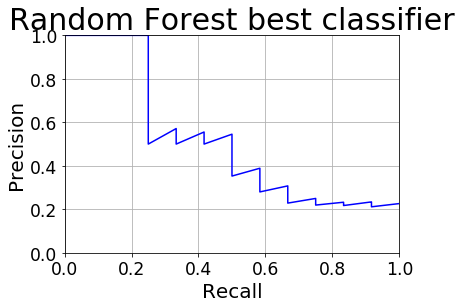

In [36]:
y_scores = cross_val_predict(RandF_best_clf, X_train_41, y_train, cv=6, method='predict_proba')
print roc_auc_score(y_train, y_scores[:,1]), "ROC AUC for"
precision, recall, proba = precision_recall_curve(y_train, y_scores[:,1])
plt_precision_vs_recall(precision, recall, title='Random Forest best classifier')

## Make predictions on test set

### Train the models

In [37]:
RandF_best_clf.fit(X_train_41, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=77, verbose=0, warm_start=False)

ROC AUC: 0.7675438596491228


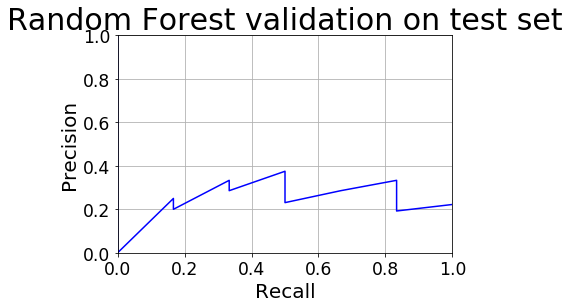

In [38]:
y_scores = RandF_best_clf.predict_proba(X_test_41)
print "ROC AUC:", roc_auc_score(y_test, y_scores[:,1])
precision, recall, proba = precision_recall_curve(y_test, y_scores[:,1])
plt_precision_vs_recall(precision, recall, title='Random Forest validation on test set')

In [39]:
RandF_best_clf.predict(X_test_41)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=uint8)

----

### Address precision/ recall trade-off

In [40]:
my_RandF = flex_classifier(RandF_best_clf, min_precision=0.3, min_recall=0.3, maximize='recall')

In [41]:
my_RandF.fit(X_train_41, y_train)

flex_classifier(classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=77, verbose=0, warm_start=False),
        maximize='recall', min_precision=0.3, min_recall=0.3,
        threshold=0.0)

#### Determine best threshold

In [42]:
from sklearn.model_selection import StratifiedShuffleSplit

In [43]:
cv = StratifiedShuffleSplit(n_splits=14, random_state=77, test_size=0.35)

In [44]:
my_RandF.det_threshold(X_train_41, y_train, replace=False)

(-0.270999, 0.5833333333333334, 0.3888888888888889)

In [45]:
thresholds = []
print "14 Loops to predict best threshold"
for train_idx, test_idx in cv.split(X_train_41, y_train):
    X_train_ = X_train_41[train_idx]
    X_test_  = X_train_41[test_idx]
    y_train_ = y_train[train_idx]
    y_test_  = y_train[test_idx]
    #print my_SGD_opt.det_threshold(X_train_, y_train_, replace=False)
    #print my_SGD_opt.feasibiliy
    thresholds.append( list(my_RandF.det_threshold(X_train_, y_train_, replace=False)))
    print "Loop", len(thresholds)
thresholds = np.array(thresholds)
best_threshold = thresholds.mean()
my_RandF.threshold = best_threshold
print "Best threshold:", best_threshold

14 Loops to predict best threshold
Loop 1


C:\Users\micha\Programs\anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Loop 2
Loop 3
Loop 4
Loop 5
Loop 6
Loop 7
Loop 8
Loop 9
Loop 10
Loop 11
Loop 12
Loop 13
Loop 14
Best threshold: 0.21967262673258892


In [46]:
my_RandF.threshold

0.21967262673258892

#### Check model on test data

In [47]:
my_RandF.predict(X_test_41)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=uint8)

In [48]:
y_predict = my_RandF.predict(X_test_41)
print confusion_matrix(y_test, y_predict)
print "Recall:", recall_score(y_test, y_predict)
print "Precision", precision_score(y_test, y_predict)

[[36  2]
 [ 6  0]]
Recall: 0.0
Precision 0.0


----

### Validate model

In [49]:
selected_features = feature_list
selected_features

['salary',
 'bonus',
 'long_term_incentive',
 'deferred_income',
 'deferral_payments',
 'other',
 'expenses',
 'director_fees',
 'total_payments',
 'exercised_stock_options',
 'restricted_stock',
 'restricted_stock_deferred',
 'total_stock_value',
 'from_this_person_to_poi',
 'from_poi_to_this_person',
 'shared_receipt_with_poi',
 'bonus_deferral_payments_rate',
 'rest_stock_deferral_payments_rate',
 'exer_stock_options_deferral_payments_rate',
 'long_term_incentive_total_payments_rate',
 'bonus_total_payments_rate',
 'exer_stock_options_total_payments_rate',
 'toPOI_rate',
 'fromPOI_rate']

In [50]:
# Features
X_train_41_df = pd.DataFrame(X_train_41, columns=selected_features, index=insiders_train)
X_test_41_df = pd.DataFrame(X_test_41, columns=selected_features, index=insiders_test)
X_41_df = X_train_41_df.append(X_test_41_df, sort=False)

# Labels
y_df = y_train.append(y_test)

# Combine features and labels 
my_dataset = X_41_df.copy()
my_dataset.insert(0, column='poi', value=y_df)

# Create dataset dict for validation
my_dataset_dict = my_dataset.transpose().to_dict() 

In [51]:
# Dump data         
dump_classifier_and_data(my_RandF, my_dataset_dict, ['poi'] + selected_features)    

In [ ]:
# Validate using tester.py 
clf, dataset, feature_list = load_classifier_and_data()
test_classifier(clf, dataset, feature_list)

---

### Save best model

In [ ]:
with open(MODELS + "SGD_model.pkl", "w") as out:
    pickle.dump(my_SGD_opt, out)

In [ ]:
with open(MODELS + "SGD_features.pkl", "w") as out:
    pickle.dump(my_dataset_dict, out)

In [ ]:
with open(MODELS + "SGD_feature_list.pkl", "w") as out:
    pickle.dump(['poi'] + selected_features, out)

In [ ]:
dump_classifier_and_data(RandF_best_clf, my_dataset_dict, ['poi'] + selected_features)  

In [ ]:
# Validate using tester.py 
clf, dataset, feature_list = load_classifier_and_data()
test_classifier(clf, dataset, feature_list)